In [2]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [3]:
df_raw= pd.read_csv("data/BigData/환율.csv", parse_dates=['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


변동 추세 확인

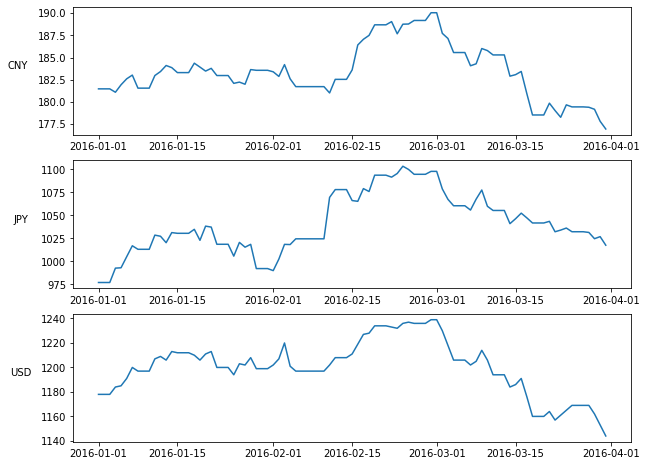

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,8))

for(ax, idx, currency) in zip([ax1, ax2, ax3], [311,312,313],['CNY','JPY','USD']):
    
    ax.plot("APPL_DATE","STD_RATE",data=df_raw[df_raw['CURRENCY']==currency])
    ax.set_ylabel(currency, rotation=0, labelpad=20)

In [9]:
df_CNY = df_raw[df_raw['CURRENCY']=="CNY"].set_index("APPL_DATE")

df_CNY.drop(['CURRENCY',"USD_CONV_DATE"],axis=1, inplace=True)

df_JPY = df_raw[df_raw['CURRENCY']=="JPY"].set_index("APPL_DATE")
df_JPY.drop(['CURRENCY','USD_CONV_DATE'], axis=1, inplace=True)

df_USD = df_raw[df_raw['CURRENCY']=="USD"].set_index("APPL_DATE")
df_USD.drop(['CURRENCY','USD_CONV_DATE'], axis=1, inplace=True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


train data 90% (시간 순서에 따라 앞에서 부터 90%를 가져옴)

In [11]:
train_size=0.9
len_idx= len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) <train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [12]:
df_CNY_train= df_CNY[mask]
df_CNY_test =df_CNY[~mask]

print("shape of train data {}".format(df_CNY_train.shape))
print("shape of test data {}".format(df_CNY_test.shape))

shape of train data (82, 1)
shape of test data (9, 1)


In [15]:
df_CNY_train = df_CNY[df_CNY.index<="2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index>"2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


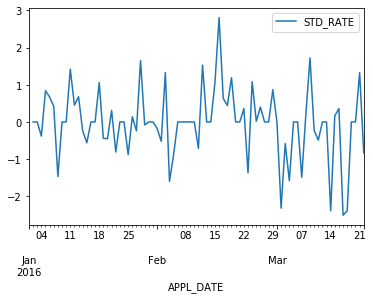

In [16]:
df_CNY_diff1= df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

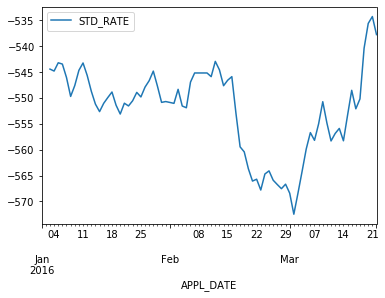

In [17]:
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1)+(df_CNY_train.shift(2)))
df_CNY_diff2.plot()

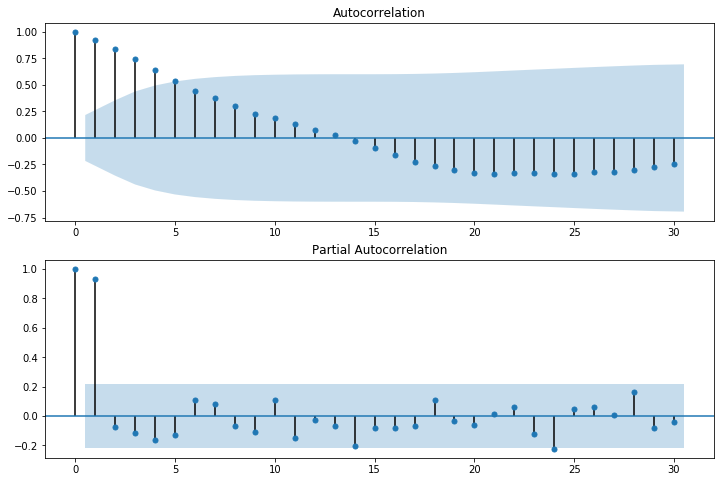

In [18]:
lag_size = 30
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'], lags = lag_size, ax=ax1)
ax2= fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'],lags =lag_size, ax=ax2)

p=1, q=0, d=2

In [19]:
ts_model_cny = ARIMA(df_CNY_train, order=(1,2,0))

# trend : 상수 포함 여부 "nc"이면 상수 미포함, full_output: 모든 출력 결과 표시
ts_result_cny = ts_model_cny.fit(trend="c", full_output=True)
print(ts_result_cny.summary())

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 25 Oct 2019   AIC                            253.025
Time:                        15:01:30   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

예측 및 결과 해석

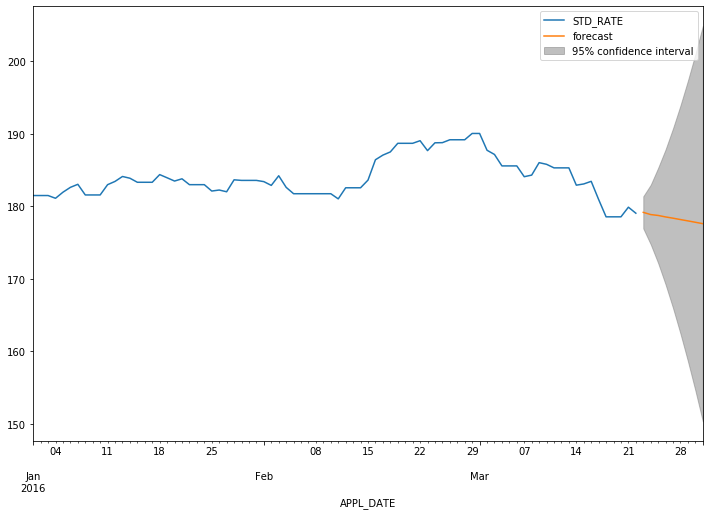

In [25]:
start_time = df_CNY_test.index.min() # 2016-03-23
end_time =df_CNY_test.index.max() # 2016-03-31

fig, ax = plt.subplots(figsize=(12,8))
ax=df_CNY_train.plot(ax=ax)

fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

            STD_RATE         예측값
APPL_DATE                       
2016-01-01    181.48         NaN
2016-01-02    181.48         NaN
2016-01-03    181.48  181.477844
2016-01-04    181.10  181.476898
2016-01-05    181.94  180.883667


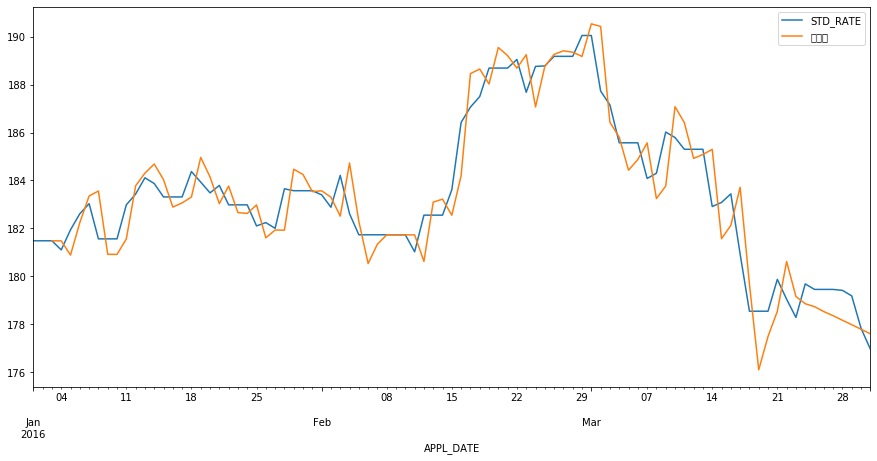

In [28]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ='levels')
df_merge=df_CNY
df_merge['예측값'] = y_pred
print(df_merge.head())

df_merge.plot(y=['STD_RATE','예측값'],figsize=(15,7))